<a href="https://colab.research.google.com/github/Maziger/master-generative-ai-with-llm/blob/main/Notebooks/Take_home_exam_assignments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Hugging face setup

In [ ]:
# Logging in
from google.colab import userdata
import os
from huggingface_hub import login
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')
login(os.environ['HF_TOKEN'])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# Assignment 1
Follow the classification example in Chapter 6 in Hands-On Generative AI with Transformers and Diffusion Models and extend it in the following ways:

## 1. Perform an error analysis based on the fine-tuned DestilBert model on the AG News dataset.

### Fine-tuning DestilBert

* Printing and logging settings
  * Wraps text and keeps notebook cleaner

In [ ]:
import datasets
import numpy as np
import torch
import transformers

np.set_printoptions(edgeitems=10, linewidth=70)
torch.set_printoptions(edgeitems=10, linewidth=70)
transformers.logging.set_verbosity_warning()
datasets.logging.set_verbosity_error()

* Load in the AG News dataset

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("ag_news")
raw_datasets

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

120.000 training rows
7.600 test rows

In [ ]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [ ]:
print(raw_train_dataset.features)

{'text': Value('string'), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'])}


* Categories: [World, Sports, Business, Sci/Tech]

* Tokenize the dataset

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )


tokenize_function(raw_train_dataset[:2])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

{'input_ids': tensor([[  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,
          1996,  2304,  1006, 26665,  1007, 26665,  1011,  2460,
          1011, 19041,  1010,  2813,  2395,  1005,  1055,  1040,
         11101,  2989,  1032,  2316,  1997, 11087,  1011, 22330,
          8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101, 18431,  2571,  3504,  2646,  3293, 13395,  1006,
         26665,  1007, 26665,  1011,  2797,  5211,  3813, 18431,
          2571,  2177,  1010,  1032,  2029,  2038,  1037,  5891,
          2005,  2437,  2092,  1011, 22313,  1998,  5681,  1032,
          6801,  3248,  1999,  1996,  3639,  3068,  1010,  2038,
          5168,  2872,  1032,  2049, 29475,  2006,  2178,  2112,
          1997,  1996,  3006,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 

* Adding input_ids and attention_mask

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

* Define evaluation metrics

In [ ]:
%pip install

import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute accuracy and F1 Score
    acc_result = accuracy.compute(references=labels, predictions=preds)
    acc = acc_result["accuracy"]

    f1_result = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )
    f1 = f1_result["f1"]

    return {"accuracy": acc, "f1": f1}

* Connect to GPU

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


* Train model

In [ ]:
from transformers import TrainingArguments

batch_size = 32  # Can be adjusted depending on GPU size
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
).to(device)
training_args = TrainingArguments(
    "assignment1_DestilBert",
    push_to_hub=True,
    num_train_epochs=2,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none" # Adding this for now as I haven't setup wandb
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer

# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)
trainer.train()

/tmp/ipython-input-2244742712.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.270980,0.909211,0.908877
2,0.303400,0.244667,0.920658,0.920620


TrainOutput(global_step=626, training_loss=0.278228912109765, metrics={'train_runtime': 731.5129, 'train_samples_per_second': 27.341, 'train_steps_per_second': 0.856, 'total_flos': 1875180164398464.0, 'train_loss': 0.278228912109765, 'epoch': 2.0})

Model showcases an F1 score on the validation set of approx. 92%

* Share model to hugging face

In [ ]:
trainer.push_to_hub(commit_message="Completed training")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...nment1_DestilBert/training_args.bin: 100%|##########| 5.78kB / 5.78kB            

  ...nment1_DestilBert/model.safetensors:  12%|#2        | 33.5MB /  268MB            

CommitInfo(commit_url='https://huggingface.co/Maziger1/assignment1_DestilBert/commit/fa488c768eb3f6c53023fce716e6fea17f678201', commit_message='Completed training', commit_description='', oid='fa488c768eb3f6c53023fce716e6fea17f678201', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Maziger1/assignment1_DestilBert', endpoint='https://huggingface.co', repo_type='model', repo_id='Maziger1/assignment1_DestilBert'), pr_revision=None, pr_num=None)

* Test if our the model works on a sample text
  * Had to make adjustments to get the correct label output

In [ ]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# Manually load model with label mapping
model = AutoModelForSequenceClassification.from_pretrained(
    "Maziger1/assignment1_DestilBert",
    id2label=raw_train_dataset.features["label"]._int2str
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("Maziger1/assignment1_DestilBert")

# Create pipeline with model and tokenizer
pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device="cuda"
)
pipe(
    """The soccer match between Spain and
Portugal ended in a terrible result for Portugal."""
)

Device set to use cuda


[{'label': 'Sports', 'score': 0.9189889430999756}]

* Plot confusion matrix

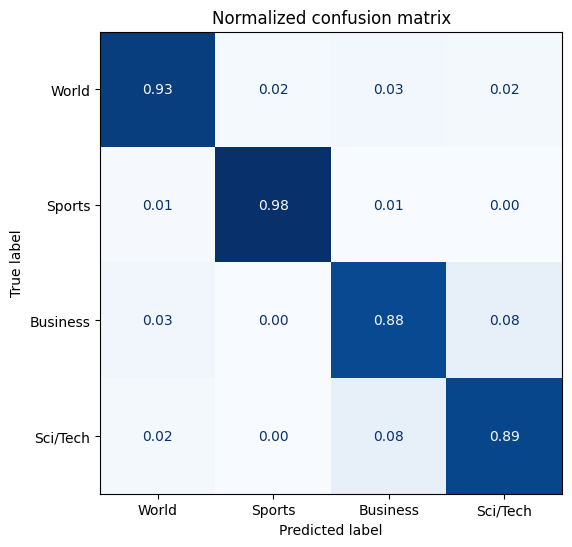

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Convert predicted labels to ids
label_to_id = {name: i for i, name in enumerate(label_names)}
# Extract the numerical part of the predicted label string (e.g., 'LABEL_2' -> 2)
pred_labels = [int(pred["label"].split('_')[1]) for pred in model_preds]

# Compute confusion matrix
confusion_matrix = evaluate.load("confusion_matrix")
cm = confusion_matrix.compute(
    references=references, predictions=pred_labels, normalize="true"
)["confusion_matrix"]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Normalized confusion matrix")
plt.show()

Noticeable that the Business category is sometimes confused with Sci/Tech (0.08). And the Sci/Tech category is sometimes confused with Business (0.08).

### Error analysis (DestilBert)

* Use GPU if available

In [ ]:
import torch
from torch.nn.functional import cross_entropy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Create label mapping function
label_names = raw_train_dataset.features["label"].names
def label_int2str(label_int):
    return label_names[label_int]

# Process one example at a time
def forward_pass_single(example):
    # Prepare inputs for a single example (values are already tensors)
    inputs = {k: example[k].unsqueeze(0).to(device)
              for k in tokenizer.model_input_names if k in example}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, example["label"].unsqueeze(0).to(device),
                           reduction="none")

    return {"loss": loss.cpu().numpy()[0],
            "predicted_label": pred_label.cpu().numpy()[0]}

In [ ]:
# Convert your test dataset to PyTorch tensors
tokenized_datasets["test"].set_format("torch",
                                     columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Process each example individually
print("Processing test dataset for error analysis...")
test_with_loss = tokenized_datasets["test"].map(forward_pass_single)

# Convert back to pandas for analysis
test_with_loss.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = test_with_loss[:][cols]

Processing test dataset for error analysis...


Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# Convert label integers to strings
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

* Sort the tokenized_datasets by model loss (high)

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
912,Bryant Makes First Appearance at Trial (AP) AP...,Sci/Tech,Sports,6.568706
1269,Philippines mourns dead in Russian school sieg...,Sci/Tech,World,6.523560
4300,City Series-ly wounded With the Yanks out of t...,Sports,Business,6.410667
1317,Florida deaths blamed on Hurricane Frances Sta...,Sports,World,6.252581
6405,Madrid miffed! The organisers of Madrid #39;s ...,Sports,World,6.076988
1197,World briefs LONDON - A man wielding a machete...,Business,World,6.067928
2126,Bush Scraps Most U.S. Sanctions on Libya (Reut...,Sci/Tech,World,6.062177
2833,Man arrested for fatally stabbing elderly pare...,Sci/Tech,World,6.025840
7228,Indonesian diplomats asked to help improve RI ...,Business,World,5.955022
5127,Another homicide in Holland It is a sad day. ...,Sci/Tech,World,5.910108


The model has trouble with predicting some of the labels, which may be due to the data itself having mislabeled some categories.

We can see that the Sci/Tech label has atleast four instances, where the text doesn't relate to that category at all. For instance, 912 being sports related, 1269 being world related etc.

Some of the business labels also seem to mislabelled in the dataset and should instead be categorised as world.

Having this information can help us refine the dataset for better performance.

* Sort the tokenized_datasets by model loss (low)

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
780,"Yemen Jails 5 Over Limburg, US Envoy Murder Pl...",World,World,0.003938
4910,Japan confirms captive in Iraq beheaded Japan ...,World,World,0.003960
7368,Kidnapped Turk Killed in Afghanistan -- Witnes...,World,World,0.003965
2137,Karzai deputy escapes a roadside bombing A dep...,World,World,0.003969
129,Peace delegation leaves Najaf empty-handed as ...,World,World,0.003975
4471,Egypt Arrests Alleged Sinai Bombers (AP) AP - ...,World,World,0.003990
775,Eritreans deported by Libya hijack a plane KHA...,World,World,0.003991
5296,France Says Hostages Still Alive a Few Days Ag...,World,World,0.003994
993,Iraq #39;s Chalabi escapes attempt on his life...,World,World,0.003996
3749,"Israel Arrests Bombing Suspect, Kills 4 Milita...",World,World,0.004006


The model is very confident when predicting the world category.

Judging from both the ascending and descending model loss, it seems like the model is good at exploiting whenever a country or geographical location is mentioned in the text, to the classify it as world. This could prove to be an issue when the model has to categorize business, which is also likely to include similar geographical keywords.

## 2. Fine-tune a ModernBert model (answerdotai/ModernBERT-base) in a similar fashion as DestilBert was fine-tuned in the chapter.

* Tokenize the dataset changing the checkpoint

In [ ]:
from transformers import AutoTokenizer

checkpoint = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )

tokenize_function(raw_train_dataset[:2])

{'input_ids': tensor([[50281, 24115,   659,    15, 34105,  1639,  1403,  8247, 40688,   253,
          5418,   313, 32680,    10, 24197,   428, 14196,    14,    84, 20945,
            13,  8799,  5720,   434,   277, 16668,  1981,    61,  4152,   273,
         17452,    14,   951,    79,   982,    13,   403,  6523,  4759,   969,
            15, 50282, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283,
         50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283, 50283],
        [50281,    36,  1285,   282, 44357, 24819,   472, 27811, 37785, 36119,
           313, 32680,    10, 24197,   428, 20859,  8149,  5882,   330,  1285,
           282,  5901,  1337,  4609,   556,   247, 12681,   323,  2403,   973,
            14, 12292,   264,   285, 13949,    61, 43961,   735,   451,  7120,
           275,   253,  5684,  4491,    13,   556, 16092,  4845,    61,   953,
         45780,   327,  1529,   629,   273,   253,  2791,    15, 50282]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 

* Adding input_ids and attention_mask

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

* Define evaluation metrics

In [ ]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute accuracy and F1 Score
    acc_result = accuracy.compute(references=labels, predictions=preds)
    acc = acc_result["accuracy"]

    f1_result = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )
    f1 = f1_result["f1"]

    return {"accuracy": acc, "f1": f1}

* Connect to GPU

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


* Train ModernBert model

In [ ]:
from transformers import TrainingArguments

batch_size = 32  # Can be adjusted depending on GPU size
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
).to(device)
training_args = TrainingArguments(
    "assignment1_ModernBert",
    push_to_hub=True,
    num_train_epochs=2,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none" # Adding this for now as I haven't setup wandb
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer

# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)
trainer.train()

/tmp/ipython-input-2244742712.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:282: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W0915 15:21:30.615000 1545 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.245964,0.915395,0.915232
2,0.275300,0.249700,0.923553,0.923460


TrainOutput(global_step=626, training_loss=0.2459266894160749, metrics={'train_runtime': 856.3633, 'train_samples_per_second': 23.355, 'train_steps_per_second': 0.731, 'total_flos': 4393473122366208.0, 'train_loss': 0.2459266894160749, 'epoch': 2.0})

* Share model to hugging face

In [ ]:
trainer.push_to_hub(commit_message="Completed training ModernBert")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...nment1_ModernBert/training_args.bin: 100%|##########| 5.78kB / 5.78kB            

  ...nment1_ModernBert/model.safetensors:   7%|6         | 41.9MB /  598MB            

CommitInfo(commit_url='https://huggingface.co/Maziger1/assignment1_ModernBert/commit/f12156decd0c7693ac216737bdeff8d5a1b343c5', commit_message='Completed training ModernBert', commit_description='', oid='f12156decd0c7693ac216737bdeff8d5a1b343c5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Maziger1/assignment1_ModernBert', endpoint='https://huggingface.co', repo_type='model', repo_id='Maziger1/assignment1_ModernBert'), pr_revision=None, pr_num=None)

## 3. Compare the test set performance of the two fine-tuned models.

* Test performance from DestilBert

In [ ]:
from transformers import Trainer

# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)
trainer.train()

/tmp/ipython-input-2244742712.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.270980,0.909211,0.908877
2,0.303400,0.244667,0.920658,0.920620


TrainOutput(global_step=626, training_loss=0.278228912109765, metrics={'train_runtime': 731.5129, 'train_samples_per_second': 27.341, 'train_steps_per_second': 0.856, 'total_flos': 1875180164398464.0, 'train_loss': 0.278228912109765, 'epoch': 2.0})

* Test performance from ModernBert

In [ ]:
from transformers import Trainer

# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)
trainer.train()

/tmp/ipython-input-2244742712.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:282: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W0915 15:21:30.615000 1545 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.245964,0.915395,0.915232
2,0.275300,0.249700,0.923553,0.923460


TrainOutput(global_step=626, training_loss=0.2459266894160749, metrics={'train_runtime': 856.3633, 'train_samples_per_second': 23.355, 'train_steps_per_second': 0.731, 'total_flos': 4393473122366208.0, 'train_loss': 0.2459266894160749, 'epoch': 2.0})

Comparing the test performance of the models:
  * Accuracy score:
    * 92.07% (DestilBert) | 92.36% (ModernBert)
  * F1 Score:
    * 92.06% (DestilBert) | 92.35% (ModernBert)
  * Validation loss:
    * 0.2447 (DestilBert) | 0.2497 (ModernBert)

We can see that the ModernBert has a slightly better performance in Accuracy and F1 Score, although DistilBert poses a better validation loss.
This slight improvement in performance is to be expected from ModernBert, as it is more powerful and efficient than DistilBert. However, both models seem to be performing quite similarly on our task, given the difference between them is so small. Overall, the accuracy of them both being above 92% is deemed high and could potentially be improven by refining the dataset as previously mentioned.

## 4. Perform an error analysis on the AG News based on the fine-tuned ModernBert and compare it to DestilBert.

### Error analysis (ModernBert)

* Load ModernBert model from HF

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.nn.functional import cross_entropy

checkpoint = "Maziger1/assignment1_ModernBert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Load trained model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint).to(device)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )

Using device: cuda


In [ ]:
# Create label mapping function
label_names = raw_train_dataset.features["label"].names
def label_int2str(label_int):
    return label_names[label_int]

# Process one example at a time
def forward_pass_single(example):
    # Prepare inputs for a single example (values are already tensors)
    inputs = {k: example[k].unsqueeze(0).to(device)
              for k in tokenizer.model_input_names if k in example}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, example["label"].unsqueeze(0).to(device), reduction="none")

    return {"loss": loss.cpu().numpy()[0],
            "predicted_label": pred_label.cpu().numpy()[0]}

In [ ]:
# Tokenize and convert test dataset to PyTorch tensors
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets["test"].set_format("torch",
                                     columns=["input_ids", "attention_mask", "label"])

In [ ]:
# Process each example individually
print("Processing test dataset for error analysis...")
test_with_loss = tokenized_datasets["test"].map(forward_pass_single)

# Convert back to pandas for analysis
test_with_loss.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = test_with_loss[:][cols]

# Convert label integers to strings
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

Processing test dataset for error analysis...


Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

* Sort the tokenized_datasets by model loss (high)

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1197,World briefs LONDON - A man wielding a machete...,Business,World,12.103226
1269,Philippines mourns dead in Russian school sieg...,Sci/Tech,World,12.072771
4396,Revolving Door &lt;em&gt; IN&lt;/em&gt;&lt;br...,World,Business,11.232325
7228,Indonesian diplomats asked to help improve RI ...,Business,World,10.588847
1364,Hyundai signs deal for China truck plant Hyund...,Sci/Tech,Business,10.376899
4097,"Greenspan: Debt, home prices not dangerous The...",Sci/Tech,Business,9.980994
2833,Man arrested for fatally stabbing elderly pare...,Sci/Tech,World,9.927932
248,Caterpillar snaps up another remanufacturer of...,Sci/Tech,Business,9.603634
5674,Will Hutton There were two stories last week t...,Business,World,9.425412
2660,Gas prices up 5 cents after Hurricane Ivan CAM...,Sci/Tech,Business,9.073890


We see some similar tendencies in ModernBert. It is also struggling with predicting labels of the indices 1269, 1197 and 7228. Which are mislabelled in the dataset and can be corrected.

Again we see that Sci/Tech is mislabelled in many instances where it properly should be categorised as Business.

* Sort the tokenized_datasets by model loss (low)

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
2108,Car Bomb Kills Three in Mosul (AP) AP - A car ...,World,World,2.384186e-07
7029,"Six Iraqi national guards, 10 civilians wounde...",World,World,3.576278e-07
1298,"Clashes in Baghdad Slum Kill 22 Iraqis, U.S. S...",World,World,4.768370e-07
999,"Gunmen ambush Chalabi #39;s convoy, wound 2 BA...",World,World,4.768370e-07
3344,Two U.S. Soldiers Killed in Iraq Bombings (AP)...,World,World,4.768370e-07
1316,Fierce Clashes in Iraq Kill 36; 203 Hurt US tr...,World,World,4.768370e-07
7197,"Four Israeli soldiers killed, Barghuti pulls o...",World,World,5.960463e-07
1299,"Fierce Clashes in Iraq Kill 34 People BAGHDAD,...",World,World,5.960463e-07
6384,UK minister visits Arafat grave UK Foreign Sec...,World,World,5.960463e-07
5403,Calif. Official Backs Anthem-WellPoint LOS AN...,Business,Business,7.152555e-07


Similarly to the DestilBert model, ModernBert is also the most confident in predicting the category World. Most likely due to the mentioning of a geographical area or a nationality.

Comparing the error analysis made on each model.

# Assignment 2
Perform the fine-tuning exercise from Chapter 6 in Hands-on Generative AI with Transformers with Transformers and Diffusion Models, but use HuggingFaceTB/SmolLM2-135M instead.
The goal is to tweak tuning parameters to get healthy looking training-validation curves and reasonable sounding output. Show examples of each from two selected training runs: One that shows warnings signs and one that shows the desired behavior.

## First model w. SmolLM2-135M

* Load dataset

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("ag_news")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

* Remove labelled data from the dataset

In [ ]:
filtered_datasets = raw_datasets.filter(lambda example: example["label"] == 2)
filtered_datasets = filtered_datasets.remove_columns("label")

* Load model SmolLM2-135M

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "HuggingFaceTB/SmolLM2-135M"
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Manually assign padding token to be the same as the end-of-text token
tokenizer.pad_token = (
    tokenizer.eos_token
)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

* Tokenize

In [ ]:
def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_datasets = filtered_datasets.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],  # We only need the input_ids and attention_mask
)

tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1900
    })
})

* Training rows: 30.000 and testing rows: 1.900

* Use datacollator to process training samples into formated batches for the training

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

* Train SmolLM2-135M (1st model)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "assignment2_SmolLM2-135M_1st",
    push_to_hub=True,
    per_device_train_batch_size=8,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    num_train_epochs=2,
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    report_to="none" # Adding this for now as I haven't setup wandb
)

* Use 10.000 samples for robust performance in training

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"].select(range(10000)),
    eval_dataset=tokenized_datasets["test"],
)

/tmp/ipython-input-2452024958.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 0}.


Step,Training Loss,Validation Loss
200,3.253400,3.350148
400,3.042200,3.268986
600,2.945300,3.189632
800,2.841800,3.126268
1000,2.676600,3.044214
1200,2.536400,2.966929
1400,1.869300,3.042451
1600,1.642100,3.009033
1800,1.556800,2.971456
2000,1.529700,2.952140


TrainOutput(global_step=2500, training_loss=2.207598297119141, metrics={'train_runtime': 614.4241, 'train_samples_per_second': 32.551, 'train_steps_per_second': 4.069, 'total_flos': 1235448660722688.0, 'train_loss': 2.207598297119141, 'epoch': 2.0})

* Plot the training vs evaluation loss

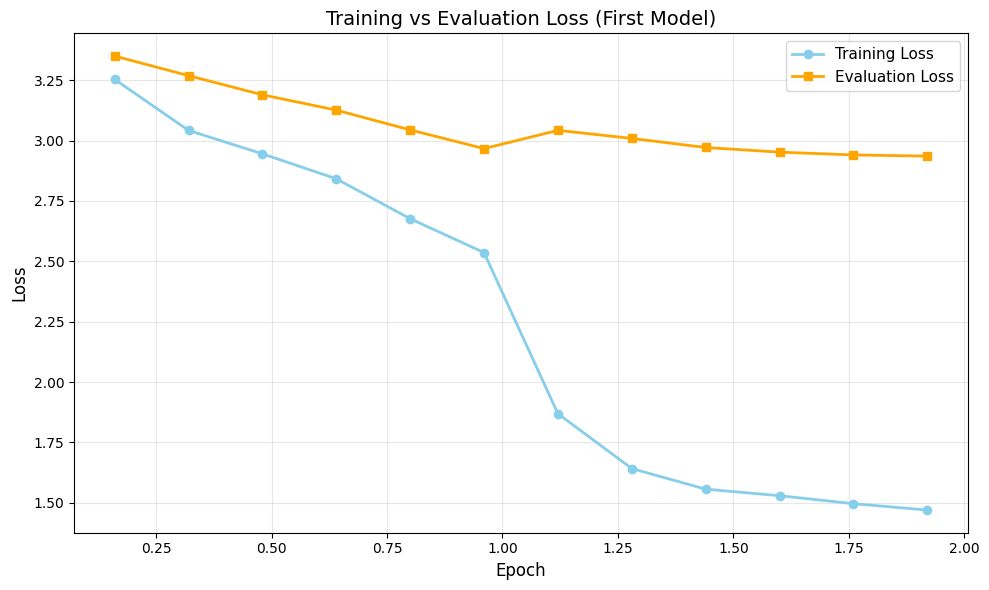

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract training history from the trainer
log_history = trainer.state.log_history

# Lists to store the data
epochs = []
train_losses = []
eval_losses = []

# Plot function
def plot_loss_history(log_history, title):
    """
    Args:
        log_history (list): A list of dictionaries containing the training log.
        title (str): The title for the plot.
    """
    train_epochs = []
    train_losses = []
    eval_epochs = []
    eval_losses = []

    for log_entry in log_history:
        if 'loss' in log_entry and 'learning_rate' in log_entry:
            train_epochs.append(log_entry['epoch'])
            train_losses.append(log_entry['loss'])
        elif 'eval_loss' in log_entry:
            eval_epochs.append(log_entry['epoch'])
            eval_losses.append(log_entry['eval_loss'])

    plt.figure(figsize=(10, 6))
    plt.plot(train_epochs, train_losses, 'o-', color='skyblue', label='Training Loss', linewidth=2, markersize=6)
    plt.plot(eval_epochs, eval_losses, 's-', color='orange', label='Evaluation Loss', linewidth=2, markersize=6)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_loss_history(trainer.state.log_history, 'Training vs Evaluation Loss (First Model)')

Our first model show warning signs and typical indicators of overfitting.

The evaluation loss does reduce during training but by a minimal amount (from 3.35 to 2.93) and is quite a poor performance given the sample amount. This is also a significantly slower reduction than the training loss (from 3.25 to 1.47) meaning the model is heavily overfitting and learning the training data too well. Thus, for the 2nd model run we change the tuning parameters.

## 2nd model w. SmolLM2-135M

* Train SmolLM2-135M (2nd model)
* Remember to reload the dataset and model when training again, otherwise it will likely cache the previous results

* In this run the following adjustments are done:
  * Increase the batch_size to 16 (reducing the training steps)
  * Slightly reducing the learning rate to 3e-5 (more stable learning)
  * Slightly increase the num_train_epochs to 3 (model sees the examples a few more times)


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    "assignment2_SmolLM2-135M_2nd",
    push_to_hub=True,
    per_device_train_batch_size=16,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=3e-5,
    num_train_epochs=3,
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    report_to="none" # Adding this for now as I haven't setup wandb
)

* Use 10.000 samples for robust performance

In [ ]:
from transformers import Trainer

trainer2 = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"].shuffle(seed=(42)).select(range(10000)),
    eval_dataset=tokenized_datasets["test"],
)

/tmp/ipython-input-4019982731.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer2 = Trainer(


In [ ]:
trainer2.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 0}.


Step,Training Loss,Validation Loss
200,3.051600,2.960070
400,2.808700,2.841698
600,2.686200,2.773933
800,2.472500,2.747335
1000,2.438100,2.722743
1200,2.434900,2.705399
1400,2.333900,2.706909
1600,2.285800,2.705265
1800,2.314700,2.703760


TrainOutput(global_step=1875, training_loss=2.528120076497396, metrics={'train_runtime': 410.0687, 'train_samples_per_second': 73.158, 'train_steps_per_second': 4.572, 'total_flos': 2173799525492736.0, 'train_loss': 2.528120076497396, 'epoch': 3.0})

* Plot training and evaluation loss

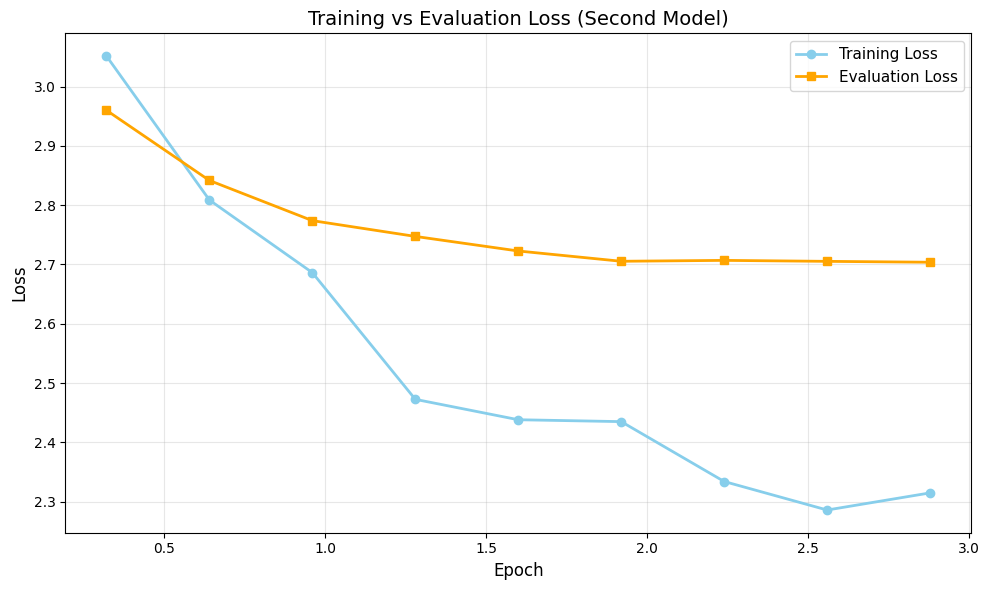

In [ ]:
plot_loss_history(trainer2.state.log_history, 'Training vs Evaluation Loss (Second Model)')

* The tweaked tuning parameters for the second model run are as follows: Increasing the batch size from 8 to 16 to reduce the amount of training steps. Slightly reduce the learning rate to get gentler parameter updates and have more stable learning. Increase the number of training epochs slightly from 2 to 3, so the model sees the examples three times and gets a bit more time to learn from the data.  

* From the plot of the second run, we notice that the model is still not optimal and doesn’t have all the healthy patterns that we are looking for. However, the curves have gotten a bit more stable, they move together more closely and the performance has gotten better overall. After adjusting the tuning parameters, we manage to improve the validation loss down to 2.7. Additionally, while the training loss is still overfitting, it is not as extreme as in the first model and the gap between the validation and training is smaller.  
